In [1]:
####################### BERT ##############################################
from transformers import DistilBertModel, DistilBertConfig
import ipywidgets
import IProgress
from transformers import DistilBertTokenizer, DistilBertForMaskedLM
import torch
###########################################################################

import numpy as np 
import pandas as pd 

###########################SKLEARN ########################################
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
###########################################################################
import os
import string 
import itertools
import copy
import matplotlib.pyplot as plt
from nltk import word_tokenize
####################### MES FONCTIONS #####################################
import os
os.chdir("C:/Users/33651/Documents/Projet_Anchors/CODE/")
from perturbation import * 
from couverture import * 
from selection_meilleur_ancre_DETERMINISTE import * 
from Perturb_Bert_One_mots import * 
from Perturb_Bert_Plusieurs_mots import *

###############PACKAGE 
import sklearn
import sklearn.model_selection
import sklearn.linear_model
import sklearn.ensemble
import spacy
import sys


#### Chargement des données provenant de Kaggle (commentaires/avis) 

In [2]:
from chargement_donnée import*

Val accuracy 0.8


In [3]:
def predict_lr(texts):
    return c.predict(vectorizer.transform(texts))

Dans l'article, nous avons vu que la méthode Anchors utilise des perturbations pour trouver le point d'ancrage et utilise deux métriques : la précision pour évaluer la puissance du point d'ancrage à stabiliser la décision, la couverture pour évaluer la région d'application (sur combien d'instance, les règles vont s'appliquer) de cette ancre.
L'objectif de Anchors est de maximiser ces deux quantités (deux problèmes d'optimisation). Dans le mémoire, nous avons pu voir que ces deux métriques sont contraires. Regardons sur un exemple :



In [4]:

## Phrase qu'on va expliquer en détail (on prend une petite phrase pour éviter qu'il y est trop de combinaison.)
phrase = "This is good computer"

print("La phrase qu'on va expliquer en détail est", phrase)
print()
## Décision prise par la classifieur pour la phrase
label = predict_lr([phrase])[0]

if label == 1 : 
    print("La phrase reflète un sentiment positif.")
else : 
    print("La phrase reflète un sentiment négatif.")

nlp = spacy.load('en_core_web_sm')

explainer = anchor_text.AnchorText(nlp, ['negative', 'positive'], use_unk_distribution=True)

#Vectorisation des données
np.random.seed(1)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform([phrase])

#Découpage des phrases en mot (chaque fois est susceptible d'appartenir à l'ancre)
ph_expli_tok= vectorizer.get_feature_names()
les_candidats = ph_expli_tok

#print("les candidats sont : ",les_candidats)



meilleur_prec = 0 #Pour sauvegarder la meilleure précision 
prec_temp = 0 #Précision temporaire => Variable qui va contenir la précision pour chaque combinaison et sera comparer à la meilleur
#Rmq : Si prec_temp est plus grand que meilleur_prec alors meilleur_prec va prendre la valeur de prec_temp ect...

best_ancre = [] #Pour sauvegarder le nom de l'ancre ayant la meilleur précision 
#On va appliquer les deux méthodes de perturbation (déterministe et générative) : 
#A la fin on va tracer un plot avec toutes les précisions => Liste de même taille que le nombre total de combinaison
precision_tous_deter = [] #Toutes les précisions (méthode déterministe)
precision_tous_bert = [] #Toutes les précisions (méthode générative = BERT)
candidat_tous = [] #Toutes les combinaisons possibles (pour tracer le plot à la fin (abscisse : candidat- ordonnée : précision)

vrai_cov = [] # On affichera aussi la couverture associée à chaque combinaison 
vrai = 0 #Variable qui contiendra le calcul de la couverture 

#Pour BERT
torch = torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(1,len(les_candidats)): #Gère la taille des combinaisons 
    
    comb_temp = [] #Combinaison qu'on étudie
    
    #print(i)    
    for c in itertools.combinations(les_candidats,i): #Itertools permet de générer toutes les combinaisons possibles de la liste les_candidats de taille i
        #La boucle parcourt les combinaisons possibles de taille i
        x= list(c) #Combinaison c de taille i (transformation en liste pour la manipulation)
        comb_temp.append(x) 
             
    for p in range(len(comb_temp)) : 
            #Si c'est le tout premier il faut initialiser les valeurs :
            #La meilleur précision est initialiser par la valeur de la toute première combinaison.
            #Dès qu'on trouve une meilleur précision, celle ci sera remplacée.
            
            if p == 0 and len(best_ancre) == 0 : #tout premier
                perturb = generation_perturb_bis4(ph_expli_tok,comb_temp[p],100,"UNK") #Génération de perturbation déterministe
                perturb_bert = generation_perturb_bert( "This is good computer",comb_temp[p], 100) #génération de perturbation générative
                
                #transformation pour la manipulation
                exp2 = np.array(perturb)
                exp2_bert = np.array(perturb_bert)
                exp3 = list(exp2)
                l =[]
                for j in range(len(exp2)):
                     l.append(exp3[j][0])
                        
                #Application de la boite noire sur les perturbations (ici déterministe)        
                resultat_deter = classif2(df,0.2,l)
               # print(resultat)
                #Calcule de la précision 
                prec_temp_deter = len(resultat_deter[resultat_deter==label])/len(resultat_deter)
                
                ###############BERT###############
                #transformation pour la manipulation
                mes_phr_perturb = []
                for pm in range(len(exp2_bert)):
                
                    phra_pe = gener_perturb_bert(exp2_bert[pm][0],"This is good computer",torch)
                
                    mes_phr_perturb.append(phra_pe)
                #print("les phrases perturbées",mes_phr_perturb)
                #Application de la boite noire sur les perturbations (ici générative)   
                resultat_bert = classif2(df,0.2,mes_phr_perturb)
               # Calcul de la précison 
                prec_temp_bert = len(resultat_bert[resultat_bert==label])/len(resultat_bert)
                #INITIALISATION DE LA MEILLEUR PRECISION
                meilleur_prec_deter = prec_temp_deter
                meilleur_prec_bert = prec_temp_bert
                
                
                #INITIALISATION DU NOM DE LA MEILLEUR ANCRE
                best_ancre_deter = comb_temp[p]
                best_ancre_bert = comb_temp[p]
                
                #AJOUT DES PRECISIONS DANS LA LISTE TOTAL DE TOUTES LES PRECISIONS QUI VA SERVIR AU PLOT (ordonnée)
                precision_tous_deter.append(meilleur_prec_deter)
                precision_tous_bert.append(meilleur_prec_bert)
                
                #CACUL DE LA COUVERTURE ASSOCIE A LA COMBINAISON
                vrai = cov_bis(comb_temp[p],sentences)
                vrai_cov.append(vrai)
                
                #AJOUT DE LA COMBINAISON A LA LISTE TOTAL DE TOUTES LES COMBINAISONS QUI VA SERVIR AU PLOT (abscisse)
                candidat_tous.append(comb_temp[p])
                #print(meilleur_prec)
            
            else: #TOUTE LES ETAPES SONT IDENTIQUE AU PREMIER IF (C'était juste l'initialisation)
                  #IL Y A JUSTE EN PLUS L'ETAPE DE COMPARAISON 
             
                candidat_tous.append(comb_temp[p])
                perturb = generation_perturb_bis4(ph_expli_tok,comb_temp[p],100,"UNK")
                perturb_bert = generation_perturb_bert( "This is good computer",comb_temp[p], 100)
                exp2 = np.array(perturb)
                exp2_bert = np.array(perturb_bert)
                
                ##################DETERMINISTE 
                exp3 = list(exp2)
                l =[]
                for j in range(len(exp2)):
                    l.append(exp3[j][0])
                resultat_deter = classif2(df,0.2,l)
               # print(resultat)
                prec_temp_deter = len(resultat_deter[resultat_deter==label])/len(resultat_deter)
                
                ############################BERT 
                mes_phr_perturb = []
                for pm in range(len(exp2_bert)):
                
                    phra_pe = gener_perturb_bert(exp2_bert[pm][0],"This is good computer",torch)
                
                    mes_phr_perturb.append(phra_pe)
                #print("les phrases perturbées",mes_phr_perturb)
                resultat_bert = classif2(df,0.2,mes_phr_perturb)
               # print(resultat)
                prec_temp_bert = len(resultat_bert[resultat_bert==label])/len(resultat_bert)
                
                #################################################################
                
                precision_tous_deter.append(prec_temp_deter)
                precision_tous_bert.append(prec_temp_bert)
                
                vrai = cov_bis(comb_temp[p],sentences)
                vrai_cov.append(vrai)
               
                # COMPARAISON - ETAPE EN PLUS 
                # Si on trouve une précision égale à la meilleure : 
                ## -> On compare la taille de la combinaison -> On remplace la valeur de l'ancre seulement si 
                ## la taille de l'ancre est inferieur ou égale (si elle est plus grande on garde la plus petite car meilleur couverture)
                ## On vérifie aussi que le seuil de précision demander est satisfait (> tau )
                if prec_temp_deter == meilleur_prec_deter and prec_temp_deter > 0.15 and len(comb_temp[p]) <= len(best_ancre_deter)  :
                    meilleur_prec_deter = prec_temp_deter
                    best_ancre = comb_temp[p]
                ## Si on trouve une précision strictement supérieur on change   
                elif prec_temp_deter > meilleur_prec_deter : 
                         meilleur_prec_deter = prec_temp_deter
                         best_ancre_deter = comb_temp[p]
                # PAREIL MAIS AVEC BERT
                if prec_temp_bert == meilleur_prec_bert and prec_temp_bert > 0.15 and len(comb_temp[p]) <= len(best_ancre_bert)  :
                    meilleur_prec_bert = prec_temp_bert
                    best_ancre_bert = comb_temp[p]
                    
                elif prec_temp_bert > meilleur_prec_bert : 
                         meilleur_prec_bert = prec_temp_bert
                         best_ancre_bert = comb_temp[p]
                        
                    



La phrase qu'on va expliquer en détail est This is good computer

La phrase reflète un sentiment positif.


On charge à nouveau les données car elles ont subit des modifications (type...) durant l'étape précedente.

In [5]:
from chargement_donnée import*

In [6]:
def predict_lr(texts):
    return c.predict(vectorizer.transform(texts))

In [7]:
text = "This is good computer"
explainer = anchor_text.AnchorText(nlp, ['negative', 'positive'], use_unk_distribution=True) #UNK

explainer2 = anchor_text.AnchorText(nlp, ['negative', 'positive'], use_unk_distribution=False ) #BERT
np.random.seed(1)

exp_UNK = explainer.explain_instance(text, predict_lr, threshold=0.95, verbose=False)
exp_BERT = explainer2.explain_instance(text, predict_lr, threshold=0.95, verbose=False)

prec_package_UNK = exp_UNK.precision()
ancre_package_UNK = exp_UNK.names()
index_ancre_UNK = candidat_tous.index(ancre_package_UNK )

list_package_UNK = [0]* len(candidat_tous)
list_package_UNK[index_ancre_UNK] = prec_package_UNK


prec_package_BERT = exp_BERT.precision() #0.9803921568627451 (aléatoire - on obtient des fois 1.0)
ancre_package_BERT = exp_BERT.names()
index_ancre_BERT = candidat_tous.index(ancre_package_BERT)

list_package_BERT = [0]* len(candidat_tous)
list_package_BERT[index_ancre_BERT] = prec_package_BERT






cov_nor = []

for i in vrai_cov : 
    cov_nor.append(i/100)

largeur_barre = 0.2


In [8]:
from IPython.display import Image


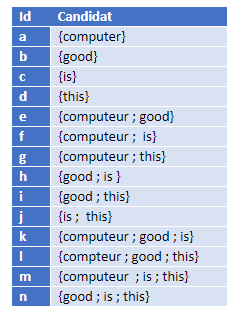

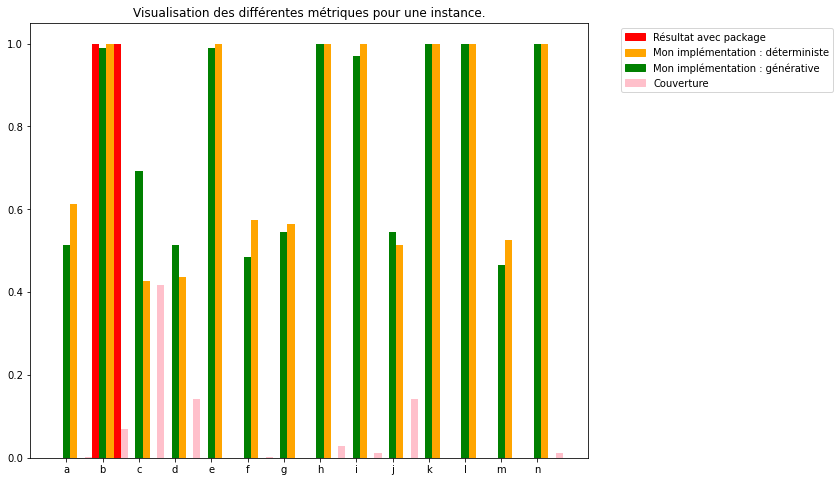

In [11]:
import matplotlib.patches as mpatches
list_aph = list(map(chr, range(97, 123))) 

list_aff = precision_tous_bert
list_aff2 = precision_tous_deter
x_moi_BERT = np.arange(len(candidat_tous))
x_pack_BERT = [i - largeur_barre for i in x_moi_BERT]
x_moi_UNK = [i + largeur_barre for i in x_moi_BERT]
x_pack_UNK = [i + 2*largeur_barre for i in x_moi_BERT]

x_cov = [i + 3*largeur_barre for i in x_moi_BERT] # Position des barres de la cat 2


plt.figure(figsize=(10,8))
plt.bar(x_pack_UNK, height=list_package_UNK,color="red",width = largeur_barre)
plt.bar(x_pack_BERT, height=list_package_BERT,color="red",width = largeur_barre)
plt.bar(x_moi_BERT, height=list_aff,color="green",width = largeur_barre)
plt.bar(x_moi_UNK, height=list_aff2,color="orange",width = largeur_barre)
plt.bar(x_cov, height=cov_nor,color="pink",width = largeur_barre)
plt.xticks(x_moi_BERT,list_aph[0:len(candidat_tous)])

colors = {'Résultat avec package':'red', 'Mon implémentation : déterministe':'orange' , 'Mon implémentation : générative':'green' , 'Couverture': 'pink'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=colors[label]) for label in labels]


plt.legend(handles, labels,bbox_to_anchor=(1.05, 1.0), loc='upper left' )

plt.title('Visualisation des différentes métriques pour une instance.')



Image("legend.png")

No handles with labels found to put in legend.


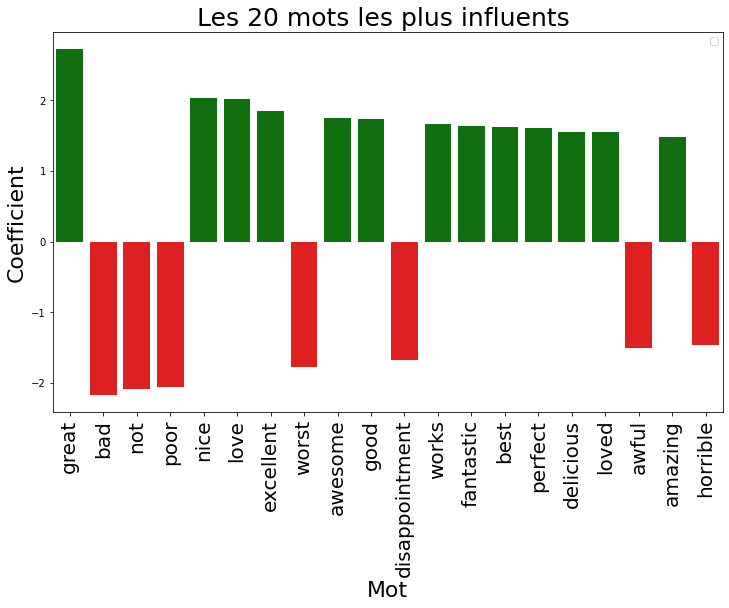

In [12]:
from sklearn.pipeline import FeatureUnion, Pipeline

model = Pipeline(
    [
        ("vectorizer",  vectorizer),
        ("transformer", TfidfTransformer()),
        ("classifier", c),
    ]
)

coefs = model.named_steps["classifier"].coef_.flatten()
feature_names = model.named_steps["vectorizer"].get_feature_names()
zipped = zip(feature_names, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

coefs = model.named_steps["classifier"].coef_.flatten()
feature_names = model.named_steps["vectorizer"].get_feature_names()
zipped = zip(feature_names, coefs)


import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Les 20 mots les plus influents ", fontsize=25)
ax.set_ylabel("Coefficient", fontsize=22)
ax.set_xlabel("Mot", fontsize=22)
ax.legend()